News2TopicsWordCloud

- ニュース記事をテキスト分析する手段として、トピックモデル(LDA)を適用
- 得られたトピックそれぞれについて、ワードクラウドを作成

In [3]:
import os
import random
import json
import requests
import pandas as pd
import numpy as np
# topic modeling
from janome.tokenizer import Tokenizer
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import japanize_matplotlib
ttf_path = japanize_matplotlib.get_font_ttf_path()

import warnings
warnings.filterwarnings("ignore")

/home/ubuntu/.pyenv/versions/3.8.10/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


## JSONデータを読み込み

crisis.yuiseki.net のクローリングしたニュース記事の一覧を取得するAPIから、JSONをとってきました。

JSONデータは次のような中身が入っています。

In [4]:
## データを取得
response_json = []
for i in range(100):
    json_url = 'https://crisis.yuiseki.net/api/news?country=%E6%97%A5%E6%9C%AC&category=poverty&limit=1000'
    json_url += f'&page={i+1}'
    print(i)
    response = requests.get(json_url)
    _response_json = response.json()
    if len(_response_json) == 0:
        break
    response_json += _response_json   

0
1


In [5]:
## 1レコードの中身
response_json[0]

{'tags': ['poverty'],
 '_id': '611871ec2fc92f71aa93502b',
 'url': 'https://www.sakigake.jp/news/article/20210815AK0007/',
 '__v': 0,
 'category': 'poverty',
 'createdAt': '2021-08-15T01:46:20.546Z',
 'latitude': 40.2118417,
 'longitude': 140.0271517,
 'ogDesc': '\u3000秋田県能代市は１６日から、経済的な理由で生理用品が購入できない人を対象に、生理用ナプキンを無償で配布する。',
 'ogImage': 'https://www.sakigake.jp/images/ogp.png',
 'ogTitle': '１６日から生理用品を配布、能代市\u3000市外からの通学者も対象｜秋田魁新報電子版',
 'ogUrl': 'https://www.sakigake.jp/news/article/20210815AK0007/',
 'placeCity': '能代市',
 'placeCountry': '日本',
 'placePref': '秋田県',
 'sourceConfirmed': True,
 'sourceName': '秋田魁新報',
 'sourceType': '新聞/地方紙',
 'title': '１６日から生理用品を配布、能代市\u3000市外からの通学者も対象｜秋田魁新報電子版twitterfeed',
 'updatedAt': '2021-08-15T02:48:58.285Z'}

In [6]:
## データフレーム化
df = pd.DataFrame(response_json)

In [7]:
len(df)

982

## タグの出現頻度

ニュース(n=860)に含まれるタグを集計しました。

「貧困(poverty)」のほか、「ウイルス(virus)」「支援(support)」「ひとり親(poverty_one_parent)」などが目立ちます。

In [8]:
## タグについて
tags = []
for _tags in df['tags'].values:
    for tag in _tags:
        tags.append(tag)
tags = pd.Series(tags)

In [9]:
## どんなタグがよくニュースに使われているのか？
cnt = tags.value_counts().to_frame(name="頻度")
cnt["出現%"] = (cnt["頻度"] / len(df) * 100).round(2)
cnt.head(10)

,頻度,出現%
poverty,806,82.08
virus,201,20.47
poverty_tech_intern,181,18.43
support,175,17.82
poverty_food,120,12.22
poverty_child,106,10.79
poverty_non_regular,74,7.54
poverty_woman,59,6.01
poverty_one_parent,59,6.01
poverty_disparity,56,5.70


## Preprocessing

LDAにかける準備として、タイトルと概要を合わせたものをテキストとみなして、形態素解析で単語分割をしました。

１文字の形態素はノイズが多いと感じたので「てにをは」のストップワードを兼ねて取り除きました。

前処理後のテキストには、タグの情報も含めました。

In [10]:
## text_corpus
text_corpus = (df['ogTitle'] + "\n\n" + df['ogDesc']).values

In [11]:
print(text_corpus[0])

１６日から生理用品を配布、能代市　市外からの通学者も対象｜秋田魁新報電子版

　秋田県能代市は１６日から、経済的な理由で生理用品が購入できない人を対象に、生理用ナプキンを無償で配布する。


In [12]:
## processed_texts
t = Tokenizer()

processed_texts = []
for (idx, row), text in zip(df.iterrows(), text_corpus):
    # break
    if pd.isna(text):
        continue
    
    processed_text = []
    
    # タイトル・概要をトークン化
    tokens = t.tokenize(text)
    for token in tokens:
        surface = token.surface.strip()
        if len(surface) <= 1:
            continue
        processed_text.append(surface)
    
    # タグ
    processed_text += [ 'tag:' + tag for tag in row['tags'] ]
    
    processed_texts.append(processed_text)

In [13]:
print(processed_texts[0])

['から', '生理', '用品', '配布', '能代', '市外', 'から', '通学', '対象', '秋田', '新報', '電子', '秋田', '能代', 'から', '経済', '理由', '生理', '用品', '購入', 'でき', 'ない', '対象', '生理', 'ナプキン', '無償', '配布', 'する', 'tag:poverty']


## LDA model

前処理済みテキストで、LDAのモデルを学習しました。

In [14]:
random.seed(42)
np.random.seed(7)
os.environ['PYTHONHASHSEED'] = '42'

In [15]:
## gensim dictionary
dictionary = Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

In [16]:
# Train LDA model.

# Set training parameters.
num_topics = 30
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
)

## pyLDAvis

可視化ツール pyLDAvis で学習結果を可視化しました。

画面右の単語のヒストグラムでは、水色部分は全体の単語頻度、赤色部分はトピックの推定単語頻度を示しています。

λはソート用のパラメータで、0に近いほど「トピックに関連性の高い単語」を、1に近いほど「トピックにおける単語の頻度」を重視してソートします。

結果はかっこいいのですが、解釈が難しく、結論には貢献しませんでした。

In [17]:
## pyLDAvis
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

/home/ubuntu/.pyenv/versions/3.8.10/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ubuntu/.pyenv/versions/3.8.10/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ubuntu/.pyenv/versions/3.8.10/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ubuntu/.pyenv/versions/3.8.10/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ubuntu/.pyenv/versions/3.8.10/lib/

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.196240 -0.128817       1        1  7.463763
13     0.157153 -0.146428       2        1  6.940774
20     0.060318  0.012290       3        1  5.080889
14    -0.000274  0.017902       4        1  4.853774
22    -0.061310 -0.098155       5        1  4.663479
12     0.026340  0.074660       6        1  4.321229
23    -0.072290 -0.050440       7        1  4.204775
11    -0.047883  0.098087       8        1  4.117250
6     -0.135899 -0.062673       9        1  3.724058
26     0.018823  0.106067      10        1  3.504260
9     -0.162042 -0.049485      11        1  3.467492
5     -0.080930 -0.061270      12        1  3.424581
15    -0.046917 -0.009951      13        1  3.146720
17     0.037247  0.103869      14        1  3.133033
4      0.049187  0.071064      15        1  2.952709
3     -0.066129  0.031052      16        1  2.947622
2      0.022822  0.071929      17        1  2.947003
8     -0.041747 -0.084349      18        1  2.847302
1      0.124185 -0.081715      19        1  2.817489
28     0.055302  0.056096      20        1  2.703191
0     -0.117820 -0.053922      21        1  2.659418
18    -0.047977  0.001314      22        1  2.645871
19     0.031878  0.070479      23        1  2.630439
7      0.002402 -0.045153      24        1  2.249863
21     0.035488  0.049146      25        1  2.191456
10     0.032384  0.002209      26        1  2.005594
25     0.075856  0.019863      27        1  1.939911
27    -0.016028 -0.006660      28        1  1.593655
29    -0.038828 -0.008217      29        1  1.483318
24     0.010450  0.101211      30        1  1.339083, topic_info=       Term        Freq       Total Category  logprob  loglift
317      実習  386.000000  386.000000  Default  30.0000  30.0000
11       生理  164.000000  164.000000  Default  29.0000  29.0000
1053     技能  332.000000  332.000000  Default  28.0000  28.0000
186      貧困  340.000000  340.000000  Default  27.0000  27.0000
1161     外国  193.000000  193.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
60    ホームレス    3.516677   67.370567  Topic30  -5.3752   1.3605
896      事件    3.107872   56.090312  Topic30  -5.4988   1.4202
1        から    3.213814  435.613406  Topic30  -5.4653  -0.5961
56      として    3.134618  209.030166  Topic30  -5.4902   0.1132
420      20    2.967915   49.771814  Topic30  -5.5449   1.4936

[2095 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
8716     16  0.891426    !!
1140      1  0.086038   ...
1140      2  0.152957   ...
1140      3  0.019120   ...
1140      4  0.009560   ...
...     ...       ...   ...
6585      4  0.168650    ＪＡ
6585     16  0.674599    ＪＡ
2533     12  0.701890  ＪＩＣＡ
8389     28  0.854094  ＫＤＤＩ
3224     16  0.891435   ＷＢＯ

[6134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 14, 21, 15, 23, 13, 24, 12, 7, 27, 10, 6, 16, 18, 5, 4, 3, 9, 2, 29, 1, 19, 20, 8, 22, 11, 26, 28, 30, 25])

## ワードクラウド

学習された lda model のそれぞれのトピックについて、ワードクラウド化を行いました。

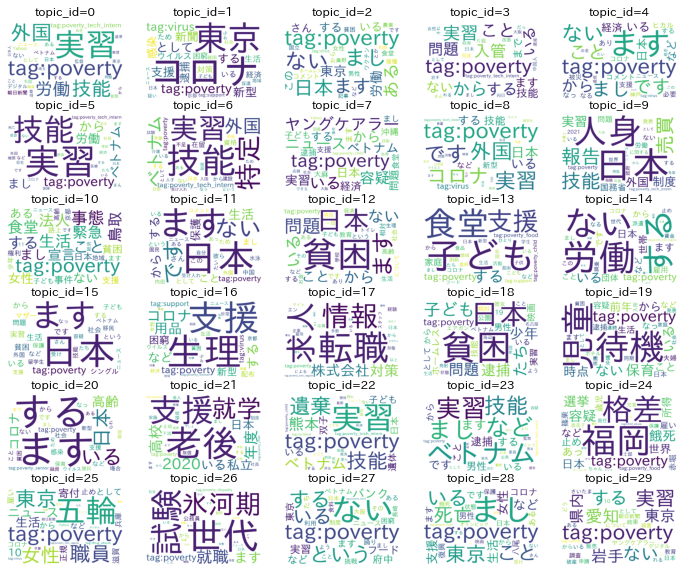

In [18]:
nrows = 6
ncols = 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(12, 10))

for i in range(ncols):
    for j in range(nrows):
        ax  = axes[j][i]
        idx = i + ncols * j
        # word cloud
        topic_id = idx
        topic_repr = model.show_topic(topicid=topic_id, topn=30)
        wc = WordCloud(background_color="white",font_path=ttf_path, width=600, height=400, random_state=42)
        # plot
        ax.imshow(wc.fit_words(dict(topic_repr)))
        ax.set_title(f'{topic_id=}')
        ax.axis('off')

## ワードクラウドの解釈

トピックごとのワードクラウドの観察より（途中で疲れたので完全ではありませんが）、以下のようなキーワードとトピックの関係が抽出されました。

```
技能実習生 id=1 id=19 id=24
片親 id=2
シングルマザー id=3
外国人留学生 id=5
子どもの貧困 id=7
高齢者 id=9
生理用品 id=10
人身売買問題 id=11
男性の貧困 id=12
待機児童 id=17
学生 id=29
```

ワードクラウドの作業を通じて、貧困の大雑把なカテゴリ分けには、たとえば以下のキーワードが利用できるのではないかと思いました。

```
老後の生活、シングルマザー、技能実習生、外国人留学生、
子供、生理用品、失職している男性、ベトナム人、生活保護
```